## Part VI: Natural Language Supervision

We will compare the performance of:

(a) traditional supervision - positive and negative labels on examples

(b) natural language supervision - explanations converted into LFs, which are then denoised and applied to unlabeled data to create a much larger but noisy training set

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os

# TO USE A DATABASE OTHER THAN SQLITE, USE THIS LINE
# Note that this is necessary for parallel execution amongst other things...
os.environ['SNORKELDB'] = 'postgres:///semparse'

import numpy as np
from snorkel import SnorkelSession
session = SnorkelSession()

We repeat our definition of the `Spouse` `Candidate` subclass from Parts II and III.

In [2]:
from snorkel.models import candidate_subclass
Spouse = candidate_subclass('Spouse', ['person1', 'person2'])

In [3]:
from snorkel.annotations import FeatureAnnotator
featurizer = FeatureAnnotator()

In [4]:
F_train = featurizer.load_matrix(session, split=0)
F_dev   = featurizer.load_matrix(session, split=1)
F_unlabeled   = featurizer.load_matrix(session, split=3)

In [5]:
from snorkel.annotations import load_gold_labels
L_gold_train = load_gold_labels(session, annotator_name='gold', split=0)
L_gold_dev = load_gold_labels(session, annotator_name='gold', split=1)

## (b) Natural Language Supervision

In [6]:
# PYTHON LFs
# from pprint import pprint
# from python_lfs import get_python_lfs

# python_lfs = get_python_lfs()
# pprint(python_lfs)
# LFs = python_lfs

[<function LF_distant_supervision at 0x127819500>,
 <function LF_distant_supervision_last_names at 0x127819578>,
 <function LF_husband_wife at 0x127819050>,
 <function LF_husband_wife_left_window at 0x1278190c8>,
 <function LF_same_last_name at 0x127819140>,
 <function LF_no_spouse_in_sentence at 0x1278191b8>,
 <function LF_and_married at 0x127819230>,
 <function LF_familial_relationship at 0x1278192a8>,
 <function LF_family_left_window at 0x127819320>,
 <function LF_other_relationship at 0x127819398>]


In [22]:
# NL LFs
spouse = ['wife', 'husband', 'ex-wife', 'ex-husband']
family = ['father', 'mother', 'sister', 'brother', 'son', 'daughter',
          'grandfather', 'grandmother', 'uncle', 'aunt', 'cousin']
family = family + [f + '-in-law' for f in family]
coworker = ['boss', 'employee', 'secretary', 'co-worker']

user_lists = {'spouse': spouse,
              'family': family,
              'coworker': coworker}

explanations = [
    "Label false because the number of words between arg 1 and arg 2 is larger than 10",
    "Label false because there is a person between arg 1 and arg 2",
    "Label true because there is at least one spouse word in the words between arg 1 and arg 2",
    "Label true because there is at least one spouse word within two words to the left of arg 1 or arg 2",
    "Label false because there are no spouse words in the sentence",
    "Label true because the word 'and' is between arg 1 and arg 2 and 'married' is to the right of arg 2",
    "Label false because there is at least one family word between arg 1 and arg 2",
    "Label false because there is at least one family word within two words to the left of arg 1 or arg 2",
    "Label false because there is at least one coworker word between arg 1 and arg 2",
    "Label false because arg 1 is identical to arg 2",
    "Label true because there is a spouse word in the sentence"
]

In [23]:
import sys
sys.path.insert(0, '/Users/bradenhancock/sippycup')

In [24]:
from sippy_snorkel_interface import SemanticParser

sp = SemanticParser()
LFs = sp.parse(explanations, user_lists=user_lists, verbose=True)

Created grammar with 148 rules
15 LFs created from 10 explanations


In [25]:
from pprint import pprint
pprint(LFs)

<function exp0_parse0 at 0x1284c2050>
<function exp1_parse0 at 0x1284c2668>
<function exp2_parse0 at 0x12d6b6c80>
<function exp3_parse0 at 0x12d6cec80>
<function exp3_parse1 at 0x12d6d3b18>
<function exp4_parse0 at 0x12d6d55f0>
<function exp5_parse0 at 0x12d6e9488>
<function exp5_parse1 at 0x12d6e9cf8>
<function exp6_parse0 at 0x12d701938>
<function exp6_parse1 at 0x12d70e230>
<function exp7_parse0 at 0x12d720c80>
<function exp7_parse1 at 0x12d735578>
<function exp8_parse0 at 0x12d6ebb90>
<function exp8_parse1 at 0x12d73be60>
<function exp9_parse0 at 0x12d6c5320>


### Investigate one LF

In [26]:
lf = LFs[5]
print lf

<function exp3_parse1 at 0x12d6d3b18>


Number labeled: 99


In [28]:
from snorkel.viewer import SentenceNgramViewer

labeled = []
for c in session.query(Spouse).filter(Spouse.split == 3).all():
    try:
        if lf(c) != 0:
            labeled.append(c)
    except:
        pass
print "Number labeled:", len(labeled)

sv = SentenceNgramViewer(labeled[:300], session)
sv

<IPython.core.display.Javascript object>

In [30]:
from snorkel.lf_helpers import test_LF
tp, fp, tn, fn = test_LF(session, lf, split=1, annotator_name='gold')

Scores (Un-adjusted)
Pos. class accuracy: 1.0
Neg. class accuracy: 0.0
Precision            0.5
Recall               1.0
F1                   0.667
----------------------------------------
TP: 6 | FP: 6 | TN: 0 | FN: 0



### Apply all LFs

In [31]:
from snorkel.annotations import LabelAnnotator
labeler = LabelAnnotator(f=LFs)

In [ ]:
np.random.seed(1701)
%time L_unlabeled = labeler.apply(split=3, parallelism=3)
L_unlabeled

In [35]:
L_unlabeled.lf_stats(session, )

,j,Coverage,Overlaps,Conflicts
exp0_parse0,0,0.258996,0.258159,0.122803
exp1_parse0,1,0.168201,0.166946,0.071548
exp2_parse0,2,0.025941,0.024268,0.023849
exp3_parse0,3,0.257741,0.257741,0.257741
exp3_parse1,4,0.015272,0.014017,0.013598
exp4_parse0,5,0.608577,0.432845,0.231172
exp5_parse0,6,0.000628,0.000628,0.000628
exp5_parse1,7,0.000628,0.000628,0.000628
exp6_parse0,8,0.040167,0.040167,0.025105
exp6_parse1,9,0.040167,0.040167,0.025105


### Generative Model

In [36]:
from snorkel.learning import GenerativeModel

gen_model = GenerativeModel()
gen_model.train(L_unlabeled, epochs=500, decay=0.95, step_size=0.1/L_unlabeled.shape[0], reg_param=1e-6)

In [37]:
train_marginals = gen_model.marginals(L_unlabeled)
print max(train_marginals)

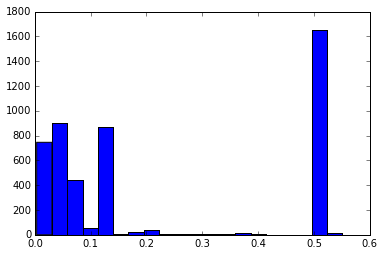

In [38]:
import matplotlib.pyplot as plt
plt.hist(train_marginals, bins=20)
plt.show()

In [39]:
L_dev = labeler.apply_existing(split=1, parallelism=3)

Clearing existing...
Running UDF...


Traceback (most recent call last):
  File "/Users/bradenhancock/anaconda/lib/python2.7/multiprocessing/queues.py", line 268, in _feed
    send(obj)
IOError: [Errno 32] Broken pipe
Process AnnotatorUDF-13:
Traceback (most recent call last):
  File "/Users/bradenhancock/anaconda/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/bradenhancock/snorkel/snorkel/udf.py", line 153, in run
    for y in self.apply(x, **self.apply_kwargs):
  File "/Users/bradenhancock/snorkel/snorkel/annotations.py", line 175, in apply
    for key_name, value in self.anno_generator(c):
  File "/Users/bradenhancock/snorkel/snorkel/annotations.py", line 341, in fn_gen
    yield f.__name__, f(c)
  File "/Users/bradenhancock/sippycup/spouses.py", line 203, in <lambda>
    '.root': lambda x: lambda c: x({'lf_helpers': lf_helpers(), 'candidate': c}),
  File "/Users/bradenhancock/sippycup/spouses.py", line 204, in <lambda>
    '.label': lambda x, y: lambda c: (-1 if not x(c

In [40]:
tp, fp, tn, fn = gen_model.score(session, L_dev, L_gold_dev)

Scores (Un-adjusted)
Pos. class accuracy: 0.0
Neg. class accuracy: 0.997
Precision            0.0
Recall               0.0
F1                   0.0
----------------------------------------
TP: 0 | FP: 1 | TN: 321 | FN: 12



In [41]:
L_dev.lf_stats(session, L_gold_dev, gen_model.weights.lf_accuracy())

,j,Coverage,Overlaps,Conflicts,TP,FP,FN,TN,Empirical Acc.,Learned Acc.
exp0_parse0,0,0.398204,0.398204,0.200599,0,0,3,127,0.976923,0.603249
exp1_parse0,1,0.281437,0.281437,0.149701,0,0,3,90,0.967742,0.570949
exp2_parse0,2,0.068862,0.065868,0.065868,10,13,0,0,0.434783,0.512161
exp3_parse0,3,0.431138,0.431138,0.431138,9,131,0,0,0.064286,0.435226
exp3_parse1,4,0.035928,0.035928,0.035928,6,6,0,0,0.500000,0.513578
exp4_parse0,5,0.883234,0.631737,0.347305,0,0,2,288,0.993103,0.712463
exp5_parse0,6,0.008982,0.008982,0.008982,1,2,0,0,0.333333,0.516759
exp5_parse1,7,0.008982,0.008982,0.008982,1,2,0,0,0.333333,0.520190
exp6_parse0,8,0.029940,0.029940,0.017964,0,0,0,10,1.000000,0.533515
exp6_parse1,9,0.029940,0.029940,0.017964,0,0,0,10,1.000000,0.532799


### Discriminative Model

In [16]:
from snorkel.learning import SparseLogisticRegression
disc_model = SparseLogisticRegression()

In [17]:
from snorkel.learning.utils import MentionScorer
from snorkel.learning import RandomSearch, ListParameter, RangeParameter

# Searching over learning rate
rate_param = RangeParameter('lr', 1e-6, 1e-2, step=1, log_base=10)
l1_param  = RangeParameter('l1_penalty', 1e-6, 1e-2, step=1, log_base=10)
l2_param  = RangeParameter('l2_penalty', 1e-6, 1e-2, step=1, log_base=10)

searcher = RandomSearch(session, disc_model, F_unlabeled, train_marginals, [rate_param, l1_param, l2_param], n=20)

Initialized RandomSearch search of size 20. Search space size = 125.


In [ ]:
np.random.seed(1701)
searcher.fit(F_dev, L_gold_dev, n_epochs=50, rebalance=True, print_freq=25)

In [ ]:
disc_model.train(F_unlabeled, train_marginals, n_epochs=20, lr=0.001)

In [ ]:
_, _, _, _ = disc_model.score(session, F_dev, L_gold_dev)